In [1]:
import scipy.io
import torch
import pickle
from torchvision import transforms
from Reader import ImageReader
import numpy as np
from image_ops import *
from similarity_ops import *
import random
from PIL import Image, ImageDraw

In [2]:
data_dict = torch.load('/pless_nfs/home/liuxiaotong2017/../datasets/CUB/data_dict_emb.pth')

In [3]:
data_transforms2 = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(256)])
dsets2 = ImageReader(data_dict['tra'], data_transforms2)

In [4]:
dsets = ImageReader(data_dict['tra'])

In [5]:
part = scipy.io.loadmat('part_info.mat')
path = scipy.io.loadmat('tra_paths.mat')

In [6]:
with open('/pless_nfs/home/liuxiaotong2017/../share_projects/CUB_14*14_conv/Arcface_CUB_tra_conv_14*14.pkl', 'rb') as f:
    tra = pickle.load(f)

In [7]:
tra_conv = torch.Tensor(tra)

In [8]:
part_list=[]

In [9]:
for idx in range(1,path['tra_paths'].shape[0]):
    info = {}
    img = dsets[idx-1]['data']
    size = img.size
    landscape = True
    if size[0]<size[1]:
        landscape = False
        
    inds_1 = part['part_image_id']==idx
    inds_2 = part['part_visible']==1
    ind = inds_1&inds_2
    these_part_x = part['part_x'][ind]
    these_part_y = part['part_y'][ind]
    these_part_types = part['part_id'][ind]
    
    
    if landscape:
        outside = np.logical_and(these_part_x<size[0]/2+size[1],these_part_x>size[1]/2)
        these_part_x = these_part_x[outside]
        these_part_y = these_part_y[outside]
        these_part_types = these_part_types[outside]
        these_part_locs_256 = np.zeros((*these_part_x.shape,2))
        these_part_locs_8 = np.zeros((*these_part_x.shape,2))
        these_part_locs_14 = np.zeros((*these_part_x.shape,2))
        new_part_x = these_part_x-(size[0]-size[1])/2
        these_part_locs_256[:,0] = new_part_x/img.size[1] *256
        these_part_locs_256[:,1] = these_part_y/img.size[1] *256
    else:
        outside = np.logical_and(these_part_y<size[1]/2+size[0],these_part_y>size[0]/2)
        these_part_x = these_part_x[outside]
        these_part_y = these_part_y[outside]
        these_part_types = these_part_types[outside]
        these_part_locs_256 = np.zeros((*these_part_x.shape,2))
        these_part_locs_8 = np.zeros((*these_part_x.shape,2))
        these_part_locs_14 = np.zeros((*these_part_x.shape,2))
        new_part_y = these_part_y-(size[1]-size[0])/2
        these_part_locs_256[:,1] = new_part_y/img.size[0] *256
        these_part_locs_256[:,0] = these_part_x/img.size[0] *256
    these_part_locs_256 = np.around(these_part_locs_256).astype(int)
    
    these_part_locs_14[:,0] = these_part_locs_256[:,0]/256 *14
    these_part_locs_14[:,1] = these_part_locs_256[:,1]/256 *14
    these_part_locs_14 = np.around(these_part_locs_14).astype(int)
    these_part_locs_14[these_part_locs_14<1] = 1
    these_part_locs_14[these_part_locs_14>14] = 14
    
    these_part_locs_8[:,0] = these_part_locs_256[:,0]/256 *8
    these_part_locs_8[:,1] = these_part_locs_256[:,1]/256 *8
    these_part_locs_8 = np.around(these_part_locs_8).astype(int)
    these_part_locs_8[these_part_locs_8<1] = 1
    these_part_locs_8[these_part_locs_8>8] = 8
    
    info['part_locs_8'] = these_part_locs_8
    info['part_locs_14'] = these_part_locs_14
    info['part_locs_256'] = these_part_locs_256
    info['part_types'] = these_part_types
    
    part_list.append(info)

In [448]:
inds_1 = part['part_image_id']==3
inds_2 = part['part_visible']==1
ind = inds_1&inds_2
part['part_id'][ind]

array([ 1,  2,  4,  5,  6,  9, 10, 11, 13, 14, 15], dtype=uint8)

In [449]:
inds_1 = part['part_image_id']==1
inds_2 = part['part_visible']==1
ind = inds_1&inds_2
part['part_id'][ind]

array([ 2,  5,  6, 10, 11, 15], dtype=uint8)

In [187]:
from PIL import Image, ImageDraw
img_test = dsets[0]['data']
img1 = ImageDraw.Draw(img_test)  
shape = shape = [(307, 178), (317, 188)]
img1.rectangle(shape, fill ="#ffffff", outline ="red")

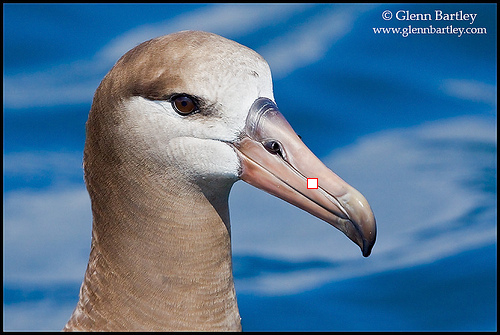

In [188]:
img_test

In [317]:
from PIL import Image, ImageDraw
img_2 = dsets[2]['data']
img2 = ImageDraw.Draw(img_2)  
shape = [(371, 155), (381, 165)]
img2.rectangle(shape, fill ="#ffffff", outline ="red")

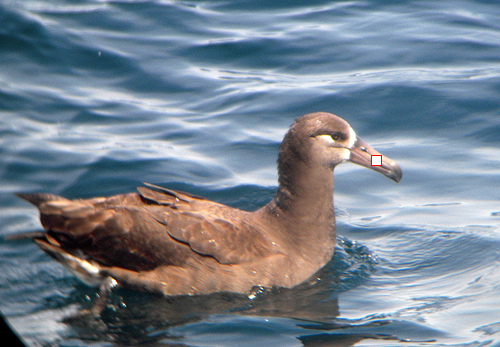

In [319]:
img_2

In [17]:
from PIL import Image, ImageDraw
def draw(image,x,y,x2=None,y2=None):
    convas = ImageDraw.Draw(image)  
    shape = [(x-7, y-7), (x+7, y+7)]
    convas.rectangle(shape, fill ="#ff00ff", outline ="white")
    if x2:
        convas2 = ImageDraw.Draw(image)
        shape2 = [(x2-7, y2-7), (x2+7, y2+7)]
        convas2.rectangle(shape2, fill ="#00ffff", outline ="white")
    return np.array(image)

In [11]:
def combine_image_and_heatmap_rgb(img,heatmap,greyscale = True):
    """
    Takes in a numpy array for an image and the similarity heatmap.
    Blends the two images together and returns a np array of the blended image.
    """
    cmap = plt.get_cmap('jet')
    heatmap = cmap(heatmap)
    if np.max(heatmap) < 255.:
        heatmap *= 255
    #heatmap_img = cv2.resize(heatmap,(256,256),interpolation = cv2.INTER_NEAREST)
    heatmap_img = cv2.resize(heatmap,(256,256),interpolation =cv2.INTER_NEAREST)
    bg = Image.fromarray(img.astype('uint8')).convert('RGB')
    if greyscale == True:
        matrix = (0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0)
        bg = bg.convert('RGB',matrix)
    fg = Image.fromarray(heatmap_img.astype('uint8')).convert('RGB')
    outIm = np.array(Image.blend(bg,fg,alpha=0.5))
    return outIm


In [12]:
def combine_image_and_heatmap_nocmap(img,heatmap,greyscale = True):
    """
    Takes in a numpy array for an image and the similarity heatmap.
    Blends the two images together and returns a np array of the blended image.
    """
    heatmap_img = cv2.resize(heatmap,(256,256),interpolation = cv2.INTER_NEAREST)
    #heatmap_img = cv2.resize(heatmap,(256,256))
    bg = Image.fromarray(img.astype('uint8')).convert('RGB')
    if greyscale == True:
        matrix = (0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0)
        bg = bg.convert('RGB',matrix)
    fg = Image.fromarray(heatmap_img.astype('uint8')).convert('RGB')
    outIm = np.array(Image.blend(bg,fg,alpha=0.5))
    return outIm

In [13]:
part_list[2]['part_types']

array([ 1,  2,  4,  5,  6, 10, 11, 13, 15], dtype=uint8)

In [14]:
def part_visual(allMaps,ind1,ind2,part_list,part_type = 2,SVD=False):
    
        line1 = []
        line2 = []
        
        Img1 = ImageReader.__getitem__(dsets2, ind1)['data']
        Img2 = ImageReader.__getitem__(dsets2, ind2)['data']
        part_locs_14_1 = part_list[ind1]['part_locs_14'][part_list[ind1]['part_types']==part_type]
        part_locs_14_2 = part_list[ind2]['part_locs_14'][part_list[ind2]['part_types']==part_type]
        
        part_locs_256_1 = part_list[ind1]['part_locs_256'][part_list[ind1]['part_types']==part_type]
        part_locs_256_2 = part_list[ind2]['part_locs_256'][part_list[ind2]['part_types']==part_type]
        
        conv1 = allMaps[ind1]
        conv2 = allMaps[ind2]
#         loc1 = max_loc(conv1)
#         loc2 = max_loc(conv2)
        loc1 = [part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
        loc2 = [part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
        if SVD:
            conv1 = conv1.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
            conv2 = conv2.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
            conv1,conv2 = turn_SVD(conv1,conv2)
        part_feat1 = conv1[part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
        conv1 = conv1.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],-1))
        
        part_feat2 = conv2[part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
        conv2 = conv2.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],-1))
        
        sim2 = vect_similarity(part_feat1,conv2)
        sim1 = vect_similarity(part_feat2,conv1)
        
        res2 = (sim2==torch.max(sim2)).nonzero().squeeze()
        res1 = (sim1==torch.max(sim1)).nonzero().squeeze()
        res1 = (res1+1) * 256//14
        res2 = (res2+1) * 256//14
        res1 = res1.int()
        res2 = res2.int()
        print(res1,res2)
        
        sim2 = np.array(sim2)
        sim1 = np.array(sim1)
        
        im1_with_similarity = combine_image_and_heatmap_rgb(np.array(Img1),sim1)
        im2_with_similarity = combine_image_and_heatmap_rgb(np.array(Img2),sim2)
        
        Img1_with_anno = draw(Img1,part_locs_256_1[0][0],part_locs_256_1[0][1],res1[1],res1[0])
        Img2_with_anno = draw(Img2,part_locs_256_2[0][0],part_locs_256_2[0][1],res2[1],res2[0])
        
        line1.append(Img1_with_anno)
        line1.append(im2_with_similarity)
        line2.append(im1_with_similarity)
        line2.append(Img2_with_anno)
        
        line1 = combine_horz(line1)
        line2 = combine_horz(line2)
        stackedImg = combine_vert([np.array(line1),np.array(line2)])
        return stackedImg

In [15]:
def svd_visual(allMaps,ind1,ind2):
    
        line1 = []
        line2 = []
        
        Img1 = ImageReader.__getitem__(dsets2, ind1)['data']
        Img2 = ImageReader.__getitem__(dsets2, ind2)['data']        
        conv1 = allMaps[ind1]
        conv2 = allMaps[ind2]
        conv1 = conv1.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
        conv2 = conv2.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))

        res1,res2 = combine_SVD(conv1,conv2)
        
#         res1 = np.array(sim2)
#         res2 = np.array(sim1)
        
        im1_with_similarity = combine_image_and_heatmap_nocmap(np.array(Img1),res1)
        im2_with_similarity = combine_image_and_heatmap_nocmap(np.array(Img2),res2)
        
        line1.append(im1_with_similarity)
        line1.append(im2_with_similarity)
        
        stackedImg = combine_horz(line1)
        return stackedImg

In [18]:
import importlib
import sys
importlib.reload(sys.modules['similarity_ops'])
from similarity_ops import *

In [537]:
stackedImg = part_test(tra_conv,0,2,part_list,part_type = 15,SVD=True)
stackedImg.save('./test_neck_SVD.jpg')

[7, 5] [6, 9]
(tensor([[5, 2]]), tensor([[ 6, 10]]))
(tensor([[3, 2]]), tensor([[ 4, 10]]))


In [19]:
def pair_test(allMaps,ind1,ind2,part_list,part_type = None,L2 = False):
    
        line1 = []
        line2 = []
        
        Img1 = ImageReader.__getitem__(dsets2, ind1)['data']
        Img2 = ImageReader.__getitem__(dsets2, ind2)['data']
        
        conv1 = allMaps[ind1]
        conv2 = allMaps[ind2]
        loc1 = max_loc(conv1)
        loc2 = max_loc(conv2)
        if part_type:
            part_locs_14_1 = part_list[ind1]['part_locs_14'][part_list[ind1]['part_types']==part_type]
            part_locs_14_2 = part_list[ind2]['part_locs_14'][part_list[ind2]['part_types']==part_type]

#             part_locs_256_1 = part_list[ind1]['part_locs_256'][part_list[ind1]['part_types']==part_type]
#             part_locs_256_2 = part_list[ind2]['part_locs _256'][part_list[ind2]['part_types']==part_type]
            loc1 = [part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
            loc2 = [part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
#         print(loc1,loc2)
        oriloc = mark_loc(conv1,conv2,loc1,loc2,L2=L2)
        conv1 = conv1.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
        conv2 = conv2.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
        conv1,conv2 = turn_SVD(conv1,conv2)
        svdloc = mark_loc(conv1,conv2,loc1,loc2,L2=L2)
        dist = np.array([torch.norm((oriloc[0]-svdloc[0]).float()),torch.norm((oriloc[1]-svdloc[1]).float())])
        return dist

In [20]:
def part_location(allMaps,ind1,ind2,part_list,part_type = None,L2 = False,SVD=False):
        line1 = []
        line2 = []
        Img1 = ImageReader.__getitem__(dsets2, ind1)['data']
        Img2 = ImageReader.__getitem__(dsets2, ind2)['data']
        conv1 = allMaps[ind1]
        conv2 = allMaps[ind2]
        loc1 = max_loc(conv1)
        loc2 = max_loc(conv2)
        if part_type:
            part_locs_14_1 = part_list[ind1]['part_locs_14'][part_list[ind1]['part_types']==part_type]
            part_locs_14_2 = part_list[ind2]['part_locs_14'][part_list[ind2]['part_types']==part_type]

#             part_locs_256_1 = part_list[ind1]['part_locs_256'][part_list[ind1]['part_types']==part_type]
#             part_locs_256_2 = part_list[ind2]['part_locs _256'][part_list[ind2]['part_types']==part_type]
#             if not part_locs_14_1 or part_locs_14_2:
#                 print([part_list[ind1]['part_types']==part_type],part_type)
#                 print([part_list[ind2]['part_types']==part_type],part_type)
            loc1 = [part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
            loc2 = [part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
#         print(loc1,loc2)
        if SVD:
                conv1 = conv1.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
                conv2 = conv2.reshape((allMaps[0].shape[0]*allMaps[0].shape[1],allMaps[0].shape[2]))
                conv1,conv2 = turn_SVD(conv1,conv2,getback = True,dim=SVD)
        oriloc = mark_loc(conv1,conv2,loc1,loc2)
        dist = np.array([torch.norm((oriloc[0]-torch.Tensor(loc1).float()).float()),torch.norm((oriloc[1]-torch.Tensor(loc2).float()).float())])
        return dist

In [30]:
part_location(tra_conv,0,2,part_list,part_type = 2,SVD=False)

array([1., 1.], dtype=float32)

In [31]:
dict_L2 = {}

In [639]:
import random
N = len(dsets)
print(data_size)
ths = 2
count = 0
for idx in range(0,10000):
    c = random.sample(dsets.intervals,1)[0]
    c = (c[0],c[1]-1)
    i,j =  random.sample(c, 2)
    dist = pair_test(tra_conv,i,j,part_list)
    n = np.count_nonzero(dist<=ths)
    count = count+n

5864


In [640]:
count/20000

0.65915

In [641]:
acc1 = count/20000

In [23]:
tra_feats = torch.mean(tra_conv,dim=(1,2))

In [24]:
tra_feats = (tra_feats.T/tra_feats.norm(dim=-1)).T

In [ ]:
import random
N = len(dsets)
print(N)
ths = 2
count = 0
for idx in range(0,10000):
#     c = random.sample(dsets.intervals,1)[0]
#     c = (c[0],c[1]-1)
    i,j =  random.sample(range(0,N), 2)
    dist = pair_test(tra_conv,i,j,part_list)
    n = np.count_nonzero(dist<=ths)
    count = count+n

5864


In [26]:
labels=np.array(list(dsets.idx_to_class.values()))

In [36]:
dists[sortedInds]

array([1.0000001 , 0.83624995, 0.8190227 , ..., 0.3199857 , 0.30497417,
       0.28838784], dtype=float32)

In [36]:
import importlib
import sys
importlib.reload(sys.modules['similarity_ops'])
from similarity_ops import *

In [21]:
typelist = [2,4,5,10,14,15]
typelist = [15]

In [29]:
ths = 2
L2=False
N=100
for Dim in [3]:
# for Dim in [3,5,7,9,11]:
    N = len(dsets)
    print(N)
    count = 0
    total = 0
    for idx in [453]:
#     for idx in range(0,N-1,1):
        if idx%100==0:
            print(idx)
        feat = tra_feats[idx]
        queryCls = labels[idx]
        sameClassInds = np.where(labels==queryCls)[0]

        dists = [np.dot(feat/np.linalg.norm(feat),f/np.linalg.norm(f)) for f in tra_feats]
        dists = np.array(dists)
        sortedInds = np.argsort(-dists)
        idx2 = random.sample(list(sortedInds[1:5]),1)[0]
        if dists[idx2]<0.8:
            continue
        part_type1 = part_list[idx]['part_types']
        part_type2 = part_list[idx2]['part_types']
        pool = list(set(part_type1) & set(part_type2) & set(typelist)) 
        if not pool:
            continue
        part_num = random.sample(pool,1)
        cond = part_location(tra_conv,idx,idx2,part_list,part_type = part_num,L2 = False,SVD=False)
        if cond[0]>0 or cond[1]>0:
            continue
        total = total + 1
    #     img = part_visual(allMaps,idx,idx2,part_list,part_type = part_num,SVD=False)
    #     img_svd = part_visual(allMaps,idx,idx2,part_list,part_type = part_num,SVD=True)
        dist = part_location(tra_conv,idx,idx2,part_list,part_type = part_num,L2 = False,SVD=Dim)
        print(dist)
        n = np.count_nonzero(dist<=ths)
        if n < 2:
            try:
                img = part_visual(tra_conv,idx,idx2,part_list,part_type = part_num,SVD=False)
                img.save('./'+str(idx)+'.jpg')
                img_svd = part_visual(tra_conv,idx,idx2,part_list,part_type = part_num,SVD=True)
                img_svd.save('./'+str(idx)+'_svd.jpg')
                img_apply = svd_visual(tra_conv,idx,idx2)
                img_apply.save('./'+str(idx)+'_act.jpg')
            except:
                continue
        count = count+n
    acc = count/2/total
    print(Dim,acc)
    acc_dict[Dim]=acc
torch.save(acc_dict,'exact_acc.pth')

5864
[1.4142135 2.236068 ]
tensor([73, 73], dtype=torch.int32) tensor([109,  73], dtype=torch.int32)
tensor([73, 91], dtype=torch.int32) tensor([73, 91], dtype=torch.int32)
3 0.5


NameError: name 'acc_dict' is not defined

In [262]:
acc_dict

{1: 0.5421810699588477}

In [168]:
count/2/total

0.9105545617173524

In [156]:
exact 10d 
0.9648
598 samples

0.9648829431438127

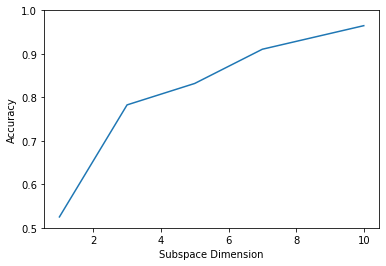

In [32]:
svdnum_dict = {}
svdnum_dict[1] = 0.525
svdnum_dict[3] = 0.7826
svdnum_dict[5] = 0.8319
svdnum_dict[7] = 0.9106
svdnum_dict[10] = 0.9648

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 

x1=[1,3,5,7,10]
y1=[0.525, 0.7826, 0.8319,0.9106,0.9648]


x=np.arange(0,10)
plt.xlabel('Subspace Dimension')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.0])
plt.plot(x1,y1,label='type1')
#plt.show()
plt.savefig('addon.jpg')

In [148]:
exact 1d
0.525
591 samples

0.7825719120135364

In [ ]:
exact 5d
0.8319
591 samples

In [ ]:
exact 3d
0.7825719120135364
591 samples

In [ ]:
exact 7d
0.9105545617173524
591 samples

In [139]:
L2 SVD reconv
0.6899476178598154

0.6899476178598154


In [ ]:
N = len(dsets)
print(N)
ths = 2
count = 0
total = 0
L2=True
for idx in range(0,N,1):
    feat = tra_feats[idx]
    queryCls = labels[idx]
    sameClassInds = np.where(labels==queryCls)[0]

    dists = [np.dot(feat/np.linalg.norm(feat),f/np.linalg.norm(f)) for f in tra_feats]
    dists = np.array(dists)
    sortedInds = np.argsort(-dists)
    idx2 = random.sample(list(sortedInds[1:10]),1)
#     if dists[idx2]<0.8:
#         continue
    total = total + 1
    dist = pair_test(tra_conv,idx,idx2[0],part_list,L2=L2)
    n = np.count_nonzero(dist<=ths)
    count = count+n
dict_L2['top10 max']=count/2/total

In [ ]:
typelist = [2,4,5,10,14,15]

In [ ]:
N = len(dsets)
print(N)
ths = 2
count = 0
total = 0
#N=10000
for idx in range(0,N-1,1):
    if idx%100==0:
        print(idx)
    feat = tra_feats[idx]
    queryCls = labels[idx]
    sameClassInds = np.where(labels==queryCls)[0]
    
    dists = [np.dot(feat/np.linalg.norm(feat),f/np.linalg.norm(f)) for f in tra_feats]
    dists = np.array(dists)
    sortedInds = np.argsort(-dists)
    idx2 = random.sample(list(sortedInds[1:10]),1)[0]
#     if dists[idx2]<0.8:
#         continue
    part_type1 = part_list[idx]['part_types']
    part_type2 = part_list[idx2]['part_types']
    pool = list(set(part_type1) & set(part_type2) & set(typelist)) 
    if not pool:
        continue
    part_num = random.sample(pool,1)
    
    part_locs_14_1 = part_list[idx]['part_locs_14'][part_list[idx]['part_types']==part_num]
    part_locs_14_2 = part_list[idx2]['part_locs_14'][part_list[idx2]['part_types']==part_num]
    loc1 = [part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
    loc2 = [part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
#         print(loc1,loc2)
    feat1 = tra_conv[idx][loc1[0],loc1[1],:].squeeze()
    feat1 = feat1/feat1.norm()
    feat2 = tra_conv[idx2][loc2[0],loc2[1],:].squeeze()
    feat2 = feat2/feat2.norm()
    sim = feat1.T@feat2
    if sim < 0.6:
        continue
    total = total + 1
    dist = pair_test(tra_conv,idx,idx2,part_list,part_type = part_num)
    n = np.count_nonzero(dist<=ths)
    count = count+n
dict_L2['top10 part>0.6']=count/2/total

In [ ]:
N = len(dsets)
print(N)
ths = 2
count = 0
total = 0
#N=10000
for idx in range(0,N-1,1):
    if idx%100==0:
        print(idx)
    feat = tra_feats[idx]
    queryCls = labels[idx]
    sameClassInds = np.where(labels==queryCls)[0]
    
    dists = [np.dot(feat/np.linalg.norm(feat),f/np.linalg.norm(f)) for f in tra_feats]
    dists = np.array(dists)
    sortedInds = np.argsort(-dists)
    idx2 = random.sample(list(sortedInds[1:5]),1)[0]
    if dists[idx2]<0.8:
        continue
    part_type1 = part_list[idx]['part_types']
    part_type2 = part_list[idx2]['part_types']
    pool = list(set(part_type1) & set(part_type2) & set(typelist)) 
    if not pool:
        continue
    part_num = random.sample(pool,1)
    
    part_locs_14_1 = part_list[idx]['part_locs_14'][part_list[idx]['part_types']==part_num]
    part_locs_14_2 = part_list[idx2]['part_locs_14'][part_list[idx2]['part_types']==part_num]
    loc1 = [part_locs_14_1[0][1]-1,part_locs_14_1[0][0]-1]
    loc2 = [part_locs_14_2[0][1]-1,part_locs_14_2[0][0]-1]
#         print(loc1,loc2)
    feat1 = tra_conv[idx][loc1[0],loc1[1],:].squeeze()
    feat1 = feat1/feat1.norm()
    feat2 = tra_conv[idx2][loc2[0],loc2[1],:].squeeze()
    feat2 = feat2/feat2.norm()
    sim = feat1.T@feat2
    if sim < 0.6:
        continue
    total = total + 1
    dist = pair_test(tra_conv,idx,idx2,part_list,part_type = part_num)
    n = np.count_nonzero(dist<=ths)
    count = count+n
dict_L2['top5>0.8 part>0.6']=count/2/total

In [94]:
dict_L2

{'top5>0.8 max': 0.31679606135201666,
 'top10 max': 0.3345839017735334,
 'top10 part>0.6': 0.756141402037148,
 'top5>0.8 part>0.6': 0.7729842308836655}

In [95]:
acc_dict

{'top5>0.8 part>0.6': 0.8216,
 'top10 part>0.6': 0.8008,
 'top10 max': 0.7276,
 'top5>0.8 max': 0.7769}

In [ ]:
torch.save(dict_L2,'L2_acc.pth')

In [75]:
total

3895

In [76]:
count

6238

In [71]:
"in top 5 >0.8  part>0.6"
0.8216486902927581

0.8216486902927581


In [72]:
"in top 10 part>0.6"
0.800770218228498

6399

In [73]:
total

3894

In [79]:
acc_dict = {}
acc_dict['top5>0.8 part>0.6']=0.8216
acc_dict['top10 part>0.6']=0.8008
acc_dict['top10 max']=0.7276
acc_dict['top5>0.8 max']=0.7769
torch.save(acc_dict,'dot_product_acc.pth')